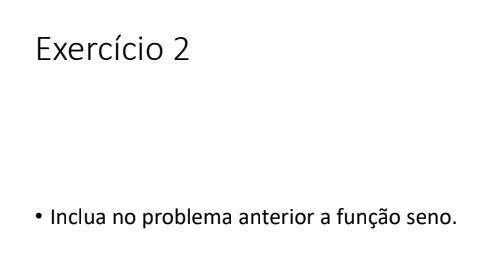

# Gerar dados artificialmente

In [1]:
import numpy as np

In [2]:
def polinomio(x):
  y = x + x**2 + x**3 + x**4
  return y

In [3]:

x = np.arange(-1, 1, 0.1)
x = x.tolist()
x

[-1.0,
 -0.9,
 -0.8,
 -0.7000000000000001,
 -0.6000000000000001,
 -0.5000000000000001,
 -0.40000000000000013,
 -0.30000000000000016,
 -0.20000000000000018,
 -0.1000000000000002,
 -2.220446049250313e-16,
 0.09999999999999964,
 0.19999999999999973,
 0.2999999999999998,
 0.3999999999999997,
 0.49999999999999956,
 0.5999999999999996,
 0.6999999999999997,
 0.7999999999999996,
 0.8999999999999995]

In [4]:
y=[]
for i in x:
  y.append(polinomio(i))
y

[0.0,
 -0.16290000000000004,
 -0.26239999999999997,
 -0.31289999999999996,
 -0.3264,
 -0.31250000000000006,
 -0.2784000000000001,
 -0.2289000000000001,
 -0.16640000000000013,
 -0.09090000000000016,
 -2.2204460492503126e-16,
 0.11109999999999956,
 0.2495999999999996,
 0.4250999999999997,
 0.6495999999999992,
 0.9374999999999986,
 1.3055999999999985,
 1.7730999999999986,
 2.3615999999999975,
 3.095099999999996]

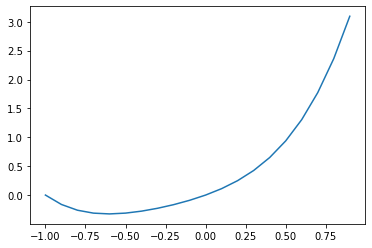

In [5]:
import matplotlib.pyplot as plt
plt.plot(x, y);

#GP

In [6]:
!pip install deap

In [7]:
# Importar bibliotecas
import operator
import math
import random
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [19]:
# Definir funções

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)   # nome do procedimento a ser gerado e o número de argumentos
pset.addPrimitive(operator.add, 2)  # funções e o número de argumentos
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(np.sin, 1) # adicionado o seno

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))                     # Minimização do erro
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)      # indivíduo

In [10]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)                  # metade genfull (toda folha tem a mesma profundidade entre min e max) metade genGrow (folhas podem ter profundidades diferente entre min e max).
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [11]:
# Função de avaliação
def evaluation(individual):
    # Transforma a expressão em árvore em uma função que pode ser chamada
    func = toolbox.compile(expr=individual)
    # Avalia o erro (MSE) entre a expressão gerada e o resultado real da função
    error = 0
    for idx, point in enumerate(x):
      error += (func(point) - y[idx])**2 
    return error,

In [12]:
# operadores
toolbox.register("evaluate", evaluation)                          # avaliação
toolbox.register("select", tools.selTournament, tournsize=3)      # seleção
toolbox.register("mate", gp.cxOnePoint)                           # crossover
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)          
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))     #limites para crossover
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))   # limites para mutação

In [13]:
random.seed(1)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40,  halloffame=hof, verbose=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [14]:
# Função encontrada
for i in hof:
  print(i)

add(mul(add(mul(protectedDiv(ARG0, ARG0), add(ARG0, mul(ARG0, mul(ARG0, ARG0)))), mul(ARG0, ARG0)), ARG0), ARG0)


In [15]:
# compila função para testarmos
gp_func = toolbox.compile(expr=hof[0])

In [16]:
# calcula y pela função gerada pelo gp
y_hat=[]
for i in x:
  y_hat.append(gp_func(i))
y_hat

[0.0,
 -0.16290000000000004,
 -0.26239999999999986,
 -0.3129,
 -0.3264,
 -0.3125,
 -0.2784000000000001,
 -0.2289000000000001,
 -0.16640000000000013,
 -0.09090000000000016,
 -2.2204460492503126e-16,
 0.11109999999999956,
 0.2495999999999996,
 0.4250999999999997,
 0.6495999999999992,
 0.9374999999999986,
 1.3055999999999985,
 1.7730999999999986,
 2.3615999999999975,
 3.095099999999996]

In [17]:
# calcula o erro quadrático
error = 0
for idx, point in enumerate(x):
  error += (gp_func(point) - y[idx])**2
error

1.8488927466117464e-32

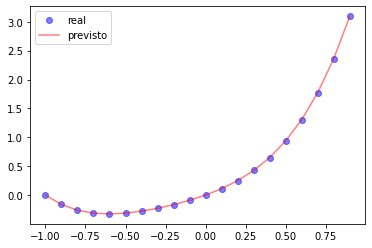

In [18]:
# plota a comparação
plt.plot(x, y, 'bo', label = 'real', color = 'blue', alpha =0.5);
plt.plot(x, y_hat, label = 'previsto', color= 'red', alpha = 0.5);
plt.legend();